In [15]:
import RC_utils as RC

ModuleNotFoundError: No module named 'RC_utils'

In [16]:
from lblTools import readTape12


ModuleNotFoundError: No module named 'lblTools'

In [31]:
import re
from typing import List, Optional
import numpy as np
import xarray as xr

def read_tape7_to_xr(path: str, species_names: Optional[List[str]] = None) -> xr.Dataset:
    """
    Parse an LBLRTM TAPE7 (IPUNCH=1) file into an xarray.Dataset.

    Parameters
    ----------
    path : str
        Path to the TAPE7 file.
    species_names : list of str, optional
        Names to assign to the molecular columns (in the order they appear in the file).
        If None, and we detect 7 or 8 species, use the standard LBLATM/TAPE7 defaults:
        7 -> ['H2O','CO2','O3','N2O','CO','CH4','O2']
        8 -> ['H2O','CO2','O3','N2O','CO','CH4','O2','N2']
        Otherwise, names are 'mol_1', 'mol_2', ...

    Returns
    -------
    xr.Dataset
        Dataset with coordinates:
          - layer: 1..N (integer)
          - species: molecular column index
        Variables:
          - p_avg [mbar], t_avg [K]
          - z_bottom [km], p_bottom [mbar], t_bottom [K]
          - z_top [km],    p_top    [mbar], t_top    [K]
          - column_amount: (layer, species)  (molecules cm^-2 if MUNITS=0; mixing ratio if MUNITS=1)
        Global attrs include parsed header info when available.

    Notes
    -----
    * TAPE7 is the “file of molecular column amounts” written when LBLATM is used
      (IATM=1) and IPUNCH=1 on Record 3.1; MUNITS controls whether these are
      columns (molec/cm^2) or mixing ratios. Species numbering follows the
      standard LBLRTM table (1:H2O, 2:CO2, …, 7:O2, 22:N2, etc.).
    """
    # float finder: accepts 1) 12.3  2) .123  3) 1.23E+04 or 1.23D+04
    fpat = re.compile(r'[+-]?(?:\d+\.\d*|\.\d+|\d+)(?:[EeDd][+-]?\d+)?')

    def floats_in(line: str) -> List[float]:
        return [float(s.replace('D','E')) for s in fpat.findall(line)]

    # Heuristic: a "layer header" line has at least 8 floats, with
    #   floats[0] ~ P_avg in [0, 2000], floats[1] ~ T_avg in [150, 400],
    #   and then 6 floats that are z/p/t at bottom and top.
    def looks_like_header(floats: List[float]) -> bool:
        if len(floats) < 8:
            return False
        pavg, tavg = floats[0], floats[1]
        return (0.0 <= pavg <= 2000.0) and (150.0 <= tavg <= 400.0)

    with open(path, 'r', errors='ignore') as f:
        lines = [ln.rstrip('\n') for ln in f]

    # Grab some header metadata if present
    header_line = next((ln for ln in lines if "H1=" in ln and "H2=" in ln), "")
    def _get(tag):
        m = re.search(rf'{tag}\s*=\s*([+-]?(?:\d+\.\d*|\.\d+|\d+))', header_line)
        return float(m.group(1)) if m else None
    meta = {
        "H1_km": _get('H1'),
        "H2_km": _get('H2'),
        "ANGLE_deg": _get('ANG'),
        "LEN_flag": _get('LEN')
    }

    # Iterate and parse blocks
    i = 0
    n = len(lines)
    layers = []
    columns_per_layer = []

    # Skip everything until we hit the first plausible header
    while i < n and not looks_like_header(floats_in(lines[i])):
        i += 1

    while i < n:
        head_floats = floats_in(lines[i])
        if not looks_like_header(head_floats):
            # no more layers
            break

        # header floats: [p_avg, t_avg, z_bot, p_bot, t_bot, z_top, p_top, t_top]
        p_avg, t_avg = head_floats[0], head_floats[1]
        z_bot, p_bot, t_bot, z_top, p_top, t_top = head_floats[2:8]
        layers.append((p_avg, t_avg, z_bot, p_bot, t_bot, z_top, p_top, t_top))

        # collect molecular columns until the next header or EOF
        i += 1
        col_vals: List[float] = []
        while i < n:
            fl = floats_in(lines[i])
            if looks_like_header(fl):
                # next layer header begins
                break
            # stop at obvious end markers, if any
            if lines[i].strip().startswith('%'):
                break
            # accumulate floats on this line (could be 0..8..16 per line)
            if fl:
                col_vals.extend(fl)
            i += 1

        # If we didn't move (empty line), advance to avoid infinite loop
        if i < n and not floats_in(lines[i]) and not looks_like_header(floats_in(lines[i])):
            i += 1

        if not col_vals:
            raise ValueError("Did not find molecular column amounts after a layer header.")

        columns_per_layer.append(np.array(col_vals, dtype=float))

    if not layers:
        raise ValueError("No layer headers detected. Is this a valid TAPE7 produced with IPUNCH=1?")

    # Ensure each layer has the same number of species entries
    ns = max(len(c) for c in columns_per_layer)
    for idx, c in enumerate(columns_per_layer):
        if len(c) != ns:
            raise ValueError(f"Inconsistent number of species: layer {idx+1} has {len(c)} vs {ns} elsewhere.")

    # Default names if none provided
    if species_names is None:
        if ns == 7:
            species_names = ['H2O','CO2','O3','N2O','CO','CH4','O2']
        elif ns == 8:
            species_names = ['H2O','CO2','O3','N2O','CO','CH4','O2','N2']
        else:
            species_names = [f"mol_{k+1}" for k in range(ns)]

    layers_arr = np.array(layers, dtype=float)
    column_arr = np.vstack(columns_per_layer)

    ds = xr.Dataset(
        data_vars=dict(
            p_avg=("layer", layers_arr[:,0]),      # mbar
            t_avg=("layer", layers_arr[:,1]),      # K
            z_bottom=("layer", layers_arr[:,2]),   # km
            p_bottom=("layer", layers_arr[:,3]),   # mbar
            t_bottom=("layer", layers_arr[:,4]),   # K
            z_top=("layer", layers_arr[:,5]),      # km
            p_top=("layer", layers_arr[:,6]),      # mbar
            t_top=("layer", layers_arr[:,7]),      # K
            column_amount=(("layer","species"), column_arr)  # molec cm^-2 if MUNITS=0; else mixing ratio
        ),
        coords=dict(
            layer=np.arange(1, layers_arr.shape[0]+1, dtype=int),
            species=np.array(species_names, dtype=object)
        ),
        attrs=dict(
            source="LBLRTM TAPE7",
            units_column_amount="molec cm^-2 (if MUNITS=0) or mixing ratio (if MUNITS=1)",
            **{k:v for k,v in meta.items() if v is not None}
        )
    )
    return ds


In [32]:
out = read_tape7_to_xr('/home/hagen/projecte/mfrsr2pwt/try_1/lblrtm/TAPE7')
out

<xarray.Dataset> Size: 4kB
Dimensions:        (layer: 1, species: 246)
Coordinates:
  * layer          (layer) int64 8B 1
  * species        (species) object 2kB 'mol_1' 'mol_2' ... 'mol_245' 'mol_246'
Data variables:
    p_avg          (layer) float64 8B 957.4
    t_avg          (layer) float64 8B 292.0
    z_bottom       (layer) float64 8B 3.0
    p_bottom       (layer) float64 8B 0.0
    t_bottom       (layer) float64 8B 1.013e+03
    z_top          (layer) float64 8B 294.2
    p_top          (layer) float64 8B 1.0
    t_top          (layer) float64 8B 902.0
    column_amount  (layer, species) float64 2kB 3.78e+22 7.708e+20 ... 2.498e+19
Attributes:
    source:               LBLRTM TAPE7
    units_column_amount:  molec cm^-2 (if MUNITS=0) or mixing ratio (if MUNIT...
    H1_km:                0.0
    H2_km:                100.0
    ANGLE_deg:            0.0
    LEN_flag:             0.0

In [28]:
import re
import numpy as np
import xarray as xr

def read_tape7(filepath, molecule_names=None):
    """
    Read a TAPE7 ASCII file from LBLRTM (IPUNCH=1) into an xarray.Dataset.
    
    Parameters
    ----------
    filepath : str
        Path to the TAPE7 file.
    molecule_names : list of str, optional
        Names for the molecular‐column output fields (in the order they appear).
        E.g. ['H2O', 'CO2', 'O3', 'N2O', 'CH4', 'CFC12', 'CFC11', 'Other'].
        If None, generic names will be used: mol0, mol1, …
    
    Returns
    -------
    ds : xarray.Dataset
        Dataset with dimension 'layer' and variables for the leading fields and the molecular columns.
    """
    layers = []
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    i = 0
    n = len(lines)
    while i < n:
        line = lines[i].strip()
        if not line:
            i += 1
            continue
        
        # Attempt to parse the “header” row for a layer
        # We expect something like: <float> <float> <int> <float> <float> <float> <float> <float> <float>
        # Then next line is many floats.
        parts = re.split(r'\s+', line)
        # If the line has at least ~9 parts and contains an integer part, treat as header
        if len(parts) >= 9 and re.match(r'^\d+$', parts[2]):
            # parse header
            altitude_or_pressure = float(parts[0])
            temperature = float(parts[1])
            intflag = int(parts[2])
            some_flag = float(parts[3])
            surface_pressure = float(parts[4])
            surface_temp = float(parts[5])
            factor1 = float(parts[6])
            value1 = float(parts[7])
            value2 = float(parts[8])
            
            # Next line: molecular columns
            i += 1
            if i >= n:
                break
            mol_line = lines[i].strip()
            mol_parts = re.split(r'\s+', mol_line)
            mol_cols = [float(v) for v in mol_parts]
            
            layers.append({
                'altitude_or_pressure': altitude_or_pressure,
                'temperature': temperature,
                'intflag': intflag,
                'some_flag': some_flag,
                'surface_pressure': surface_pressure,
                'surface_temp': surface_temp,
                'factor1': factor1,
                'value1': value1,
                'value2': value2,
                'molecular_columns': mol_cols
            })
        else:
            # Not a recognized header line, skip
            i += 1
            continue
        
        i += 1
    
    # Now build xarray.Dataset
    n_layers = len(layers)
    # assume all have the same number of mol_columns
    n_mols = len(layers[0]['molecular_columns'])
    
    # Prepare data arrays
    alt = np.array([lay['altitude_or_pressure'] for lay in layers])
    temp = np.array([lay['temperature'] for lay in layers])
    intflag = np.array([lay['intflag'] for lay in layers])
    some_flag = np.array([lay['some_flag'] for lay in layers])
    surface_pressure = np.array([lay['surface_pressure'] for lay in layers])
    surface_temp = np.array([lay['surface_temp'] for lay in layers])
    factor1 = np.array([lay['factor1'] for lay in layers])
    value1 = np.array([lay['value1'] for lay in layers])
    value2 = np.array([lay['value2'] for lay in layers])
    mol_cols = np.array([lay['molecular_columns'] for lay in layers])
    
    if molecule_names is None:
        molecule_names = [f'mol{i}' for i in range(n_mols)]
    elif len(molecule_names) != n_mols:
        raise ValueError(f"molecule_names length {len(molecule_names)} != number of mol columns {n_mols}")
    
    ds = xr.Dataset(
        {
            'altitude_or_pressure': ('layer', alt),
            'temperature': ('layer', temp),
            'intflag': ('layer', intflag),
            'some_flag': ('layer', some_flag),
            'surface_pressure': ('layer', surface_pressure),
            'surface_temp': ('layer', surface_temp),
            'factor1': ('layer', factor1),
            'value1': ('layer', value1),
            'value2': ('layer', value2),
        },
        coords={'layer': np.arange(n_layers)}
    )
    
    # add molecular columns
    for j, name in enumerate(molecule_names):
        ds[name] = (('layer',), mol_cols[:, j])
    
    return ds


In [20]:
def readTape7(fName, sList=False):
  """
  Read LBLRTM TAPE7 ASCII file (molecular amounts computed by LBLATM)

  Call
    ll = readTape7(fName)

  Input
    fName -- string, full path to TAPE7 to be read

  Output
    ll -- 

  Keywords
    sList -- 
  """

  def cnvline(l, fmt=','):
    ll = re.split(fmt, l.strip())
    ll = map(float, ll)
    return ll
  # end cnvline()

  f = open(fName)
  l = f.readlines()
  f.close()
  ll = []
  l = l[2:]

  # loop over layers (this may be assuming a certain number of 
  # molecules, or at least the number should not exceed a threshold 
  # of 7)
  for i in range(0, len(l), 2):
    q = re.split(r'\s+', l[i].strip())
    if not i:
      try:
        if sList:
          q = [float(q[0]), float(q[1]), float(q[6]),
               float(q[6]) - float(q[3])]
        else:
          q = [[float(q[0]), float(q[4]), float(q[7])],
               [float(q[1]), float(q[5]), float(q[8])],
               float(q[6]), float(q[6]) - float(q[3])]
        # endif sList
      except (KeyboardInterrupt, SystemExit):
        raise
      except (IndexError,ValueError):
        q = [float(q[0]), float(q[1]), 0, 0]
    else:
      ind = len(ll) - 1
      if sList:
        q2 = ll[ind][2]
        try:
          q = [float(q[0]), float(q[1]), float(q[3]),
               float(q[3]) - q2]
        except (IndexError,ValueError):
          zz = re.split(r'\.', q[3])
          q3 = float(zz[0] + zz[1])
          q = [float(q[0]), float(q[1]), q3, q3 - q2]
      else:
        q0 = ll[ind][0][2]
        q1 = ll[ind][1][2]
        q2 = ll[ind][2]
        q = [[float(q[0]), q0, float(q[4])], [float(q[1]), q1,
             float(q[5])], float(q[3]), float(q[3]) - q2]
      # endif sList

    q += cnvline(l[i + 1].strip(), fmt=r'\s+')
    ll.append(q)
  # end loop over lines

  return ll

In [5]:
ds = read_tape27_head('/home/hagen/projecte/mfrsr2pwt/run_examples/run_example_solar_downwelling_kurucz/TAPE27_ex')

In [7]:
ds2 = read_tape27_head('/home/hagen/projecte/mfrsr2pwt/run_examples/run_example_solar_downwelling_kurucz/TAPE27_test')

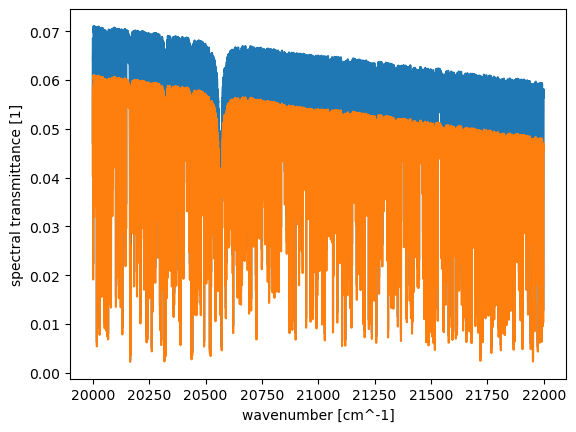

In [8]:
ds.transmittance.plot()
ds2.transmittance.plot()

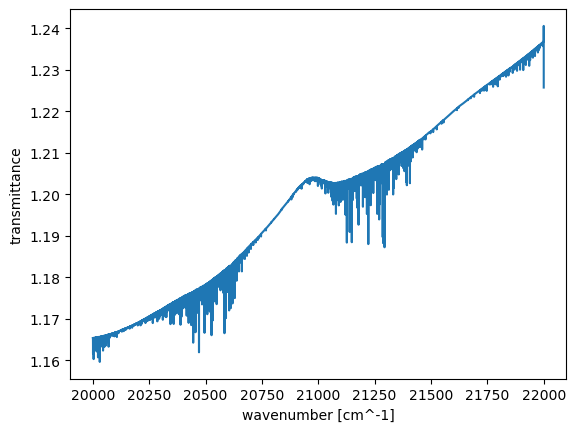

In [9]:
(ds.transmittance / ds2.transmittance).plot()

In [10]:
ds

<xarray.Dataset> Size: 11MB
Dimensions:        (wavenumber: 472531)
Coordinates:
  * wavenumber     (wavenumber) float64 4MB 2e+04 2e+04 ... 2.2e+04 2.2e+04
    wavelength_nm  (wavenumber) float64 4MB 500.0 500.0 500.0 ... 454.5 454.5
Data variables:
    transmittance  (wavenumber) float64 4MB 0.06844 0.0683 ... 0.05671 0.05699
Attributes:
    lblrtm_timestamp:  2023-01-04T11:19:32
    initial_layer:     1
    final_layer:       18
    secant:            0.0
    pressure_mb:       506.53246
    temperature_k:     258.0
    dv_cm^-1:          0.00423253
    v1_cm^-1:          20000.0
    v2_cm^-1:          22000.0
    source:            LBLRTM TAPE27 (transmittance)

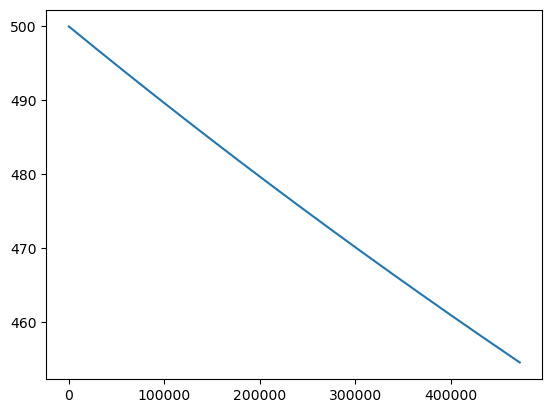

In [14]:
plt.plot(ds.wavelength_nm)